# PART 1: Train and Scan the model in-line

# Typical flow for a Data Scientist during Development

## What we will Learn

1. In this tutorial we will create sklearn models to classify [german credit loan risk](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) (predict whether loan will be granted or not)

2. Configure Certifai Scan

3. Run Certifai Scan

4. View Results for Fairness, Robustness, Explanations and Explanability

## Documentation

Visit the Certifai Documentation here https://cognitivescale.github.io/cortex-certifai/docs/about

## Prerequisites

If you are using an Azure Machine Learning Notebook VM, you are all set. Otherwise, make sure you go through the 
[configuration-notebook](https://github.com/Azure/MachineLearningNotebooks/blob/c520bd1d4130d9a01ee46e0937459e2de95d15ec/configuration.ipynb) to create an Azure workspace. Creating local and remote environments/dependencies will be covered in the notebook

**PleaseNote**: to step through this notebook, make sure you have necessary dependencies installed locally

- python>=3.6.2,<3.7
- scikit-learn=0.20.3
- numpy=1.16.2
- pandas
- azureml-sdk=1.4.0
- ipython
- matplotlib
- jupyter

You can also use [Conda](https://docs.conda.io/projects/conda/en/latest/user-guide/install/) to create the local environment using the `certifai_azure_model_env.yml` file provided with the notebook

Open your favorite terminal and cd into folder where this notebook is located to execute the below commands

- `conda env create -f certifai_azure_model_env.yml` : will create local conda env with the necessary python packages for working through the notebook
- `jupyter-notebook` : to launch jupyter notebook sesssion. 


**Note**: Installing `Cortex-Certifai` packages will be covered separately

### Set Cortex Certifai Toolkit path
- update the `certifai_toolkit_path` to point your downloaded toolkit
- this will be used later to install cortex certifai python packages

In [1]:
from pathlib import Path

In [2]:
pwd = !pwd

In [3]:
my_path = str(Path(pwd[0]).parents[0])

In [4]:
certifai_toolkit_path = my_path  + '/certifai_toolkit_1.3.2'
certifai_toolkit_path

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/sko-compute-1-3-2i/code/users/skottaram/msft-workshop/certifai_toolkit_1.3.2'

## Creating a [german credit](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) prediction model using sklearn

In [5]:
# required imports for model building and persistance 

import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import random
from sklearn.externals import joblib

### Test to confirm correct version of scikit-learn and numpy are installed

In [6]:
import sklearn as sklearn_version_test
assert sklearn_version_test.__version__ == '0.20.3', 'scikit-learn version mismatch, `pip install scikit-learn==0.20.3` to install right sklearn version for this notebook'
assert np.__version__                   == '1.16.2', 'numpy version mismatch, `pip install numpy==1.16.2` to install right numpy version for this notebook'

In [7]:
# special import - 
# for multiprocessing to work in a Notebook,  pickled classes must be in a separate package or notebook
# hence, the model encoder class has to be somewhere other than the current notebook

import os
import sys
sys.path.insert(0, os.path.abspath(os.path.join('.')))
from scripts.cat_encoder import CatEncoder

###  load data in dataframe

In [8]:
# load the dataset into memory
df = pd.read_csv('data/german_credit_eval.csv')

In [9]:
df_sample = df.sample(100)

### define features 

In [10]:
cat_columns = [
    'checkingstatus',
    'history',
    'purpose',
    'savings',
    'employ',
    'status',
    'others',
    'property',
    'age',
    'otherplans',
    'housing',
    'job',
    'telephone',
    'foreign'
    ]

label_column = 'outcome'

### separate features and target variable

In [11]:
y = df[label_column]
X = df.drop(label_column, axis=1)

### split dataset into the training and test set

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### encode and scale features

In [13]:
encoder = CatEncoder(cat_columns, X)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


### build and train model using sklearn

In [14]:
import warnings
warnings.filterwarnings('ignore')
def build_model(data, name, model_family, test=None):
    if test is None:
        test = data
        
    if model_family == 'SVM':
        parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[0.1, .5, 1, 2, 4, 10], 'gamma':['auto']}
        m = svm.SVC()
    elif model_family == 'logistic':
        parameters = {'C': (0.5, 1.0, 2.0), 'solver': ['lbfgs'], 'max_iter': [1000]}
        m = LogisticRegression()
    model = GridSearchCV(m, parameters, cv=3)
    model.fit(data[0], data[1])

    # Assess on the test data
    accuracy = model.score(test[0], test[1].values)
    print(f"Model '{name}' accuracy is {accuracy}")
    return model

svm_model_name      = 'german_credit_svm'
logistic_model_name = 'german_credit_logit'

svm_model = build_model((encoder(X_train.values), y_train),
                        svm_model_name,
                        'SVM',
                        test=(encoder(X_test.values), y_test))

logistic_model = build_model((encoder(X_train.values), y_train),
                        logistic_model_name,
                        'logistic',
                        test=(encoder(X_test.values), y_test))

Model 'german_credit_svm' accuracy is 0.77
Model 'german_credit_logit' accuracy is 0.77


## Running Cortex Certifai Scan

1. Install the cortex certifai packages required to initiate model scan

2. Configure scan details and execute


## Installing Cortex Certifai python packages

initiating a Cortex Certifai scan requires following python packages to be installed in the current local environment

`required-packages`

- cortex-certifai-scanner
- cortex-certifai-engine
- cortex-certifai-common

`optional-packages`

- cortex-certifai-client
- cortex-certifai-console

Download [certifai toolkit](https://www.cognitivescale.com/download-certifai) and follow instructions in the `Readme.md` to install the python-packages in the current environment

### Install required certifai packages (optional packages are left for user to install)


In [15]:
!find $certifai_toolkit_path/packages/all       -type f ! -name "*console-*" ! -name "*client-*" | xargs -I % sh -c 'pip install % ' ;
!find $certifai_toolkit_path/packages/python3.6 -type f   -name "*engine-*"                      | xargs -I % sh -c 'pip install % ' ;


Processing /mnt/batch/tasks/shared/LS_root/mounts/clusters/sko-compute-1-3-2i/code/users/skottaram/msft-workshop/certifai_toolkit_1.3.2/packages/all/cortex-certifai-common-1.3.2-4-g8648134d.zip
  Created wheel for cortex-certifai-common: filename=cortex_certifai_common-1.3.2-py3-none-any.whl size=73982 sha256=58334e46c1734362ca7764636a71f27a0881d531a41cee86a16cd3f0c2eadcd9
  Stored in directory: /home/azureuser/.cache/pip/wheels/de/db/6f/b79a8b513409877efab5a79de6d2da6ef5b674bb555f3b9aa3
Successfully built cortex-certifai-common
  Attempting uninstall: cortex-certifai-common
    Found existing installation: cortex-certifai-common 1.3.2
    Uninstalling cortex-certifai-common-1.3.2:
      Successfully uninstalled cortex-certifai-common-1.3.2
Processing /mnt/batch/tasks/shared/LS_root/mounts/clusters/sko-compute-1-3-2i/code/users/skottaram/msft-workshop/certifai_toolkit_1.3.2/packages/all/cortex-certifai-connectors-1.3.2-4-g8648134d.zip
  Created wheel for cortex-certifai-connectors: fil

In [16]:
# make sure certifai package was installed correctly
from certifai.scanner.version import get_version
get_version()

'1.3.2'

In [17]:
import pandas as pd

### Using Cortex Certifai python-package to launch a scan

\### define cortex certifai task type

- `CertifaiTaskOutcomes` : cortex certifai supports classification as well as regression models. here we have an example of binary-classification (e.g. predict whether loan should be granted or not)
- `CertifaiOutcomeValue` : define the different outcomes possible from the model predictions. here we have a model that predicts either 1(loan granted) or 2(loan denied)

**Note**: Please refer to [Certifai Api Docs](https://cognitivescale.github.io/cortex-certifai/certifai-api-ref/certifai.scanner.builder.html) for more details

In [18]:
df = pd.read_csv("data/german_credit_eval.csv")
df_sample = df.sample(100)

In [19]:
from certifai.scanner.builder import (CertifaiScanBuilder, CertifaiPredictorWrapper, CertifaiModel, CertifaiModelMetric,
                                      CertifaiDataset, CertifaiGroupingFeature, CertifaiDatasetSource,
                                      CertifaiPredictionTask, CertifaiTaskOutcomes, CertifaiOutcomeValue, CertifaiPredictorWrapper)
from certifai.scanner.report_utils import scores, construct_scores_dataframe

In [20]:
svm_model_proxy = CertifaiPredictorWrapper(svm_model, encoder=encoder)
logistic_model_proxy = CertifaiPredictorWrapper(logistic_model, encoder=encoder)

In [21]:
# Create the scan object from scratch using the ScanBuilder class with tasks and outcomes

# First define the possible prediction outcomes
task = CertifaiPredictionTask(CertifaiTaskOutcomes.classification(
    [
        CertifaiOutcomeValue(1, name='Loan granted', favorable=True),
        CertifaiOutcomeValue(2, name='Loan denied')
    ]),
    prediction_description='Determine whether a loan should be granted')

In [22]:
# Fairness Scan Setup

In [23]:
#  create a certifai scan object and add the certifai task created above
fairness_scan = CertifaiScanBuilder.create('model_auth_demo_fairness',
                                  prediction_task=task)

In [24]:
# Create a Certifai Model Object using the web service (from earlier) by passing the deployed web service url
first_model = CertifaiModel('SVM',
                            local_predictor=svm_model_proxy)
fairness_scan.add_model(first_model)

second_model = CertifaiModel('logistic',
                            local_predictor=logistic_model_proxy)
fairness_scan.add_model(second_model)

# Add corresponding model headers for service authentication and content-type

# add the default headers applicable to all models
fairness_scan.add_model_header(header_name='Content-Type',header_value='application/json')

In [25]:
# german_credit_eval_data_file = 'data/german_credit_eval_100.csv'
eval_dataset = CertifaiDataset('evaluation',
                               CertifaiDatasetSource.dataframe(df_sample))
fairness_scan.add_dataset(eval_dataset)

In [26]:
# Setup an evaluation for fairness on the above dataset using the model
# We'll look at disparity between groups defined by marital status and age
fairness_scan.add_fairness_grouping_feature(CertifaiGroupingFeature('age'))
fairness_scan.add_fairness_grouping_feature(CertifaiGroupingFeature('status'))
fairness_scan.add_evaluation_type('fairness')
fairness_scan.evaluation_dataset_id = 'evaluation'

In [27]:
# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
fairness_scan.dataset_schema.outcome_feature_name = 'outcome'

In [28]:
# Run the scan.
# By default this will write the results into individual report files (one per model and evaluation
# type) in the 'reports' directory relative to the Jupyter root.  This may be disabled by specifying
# `write_reports=False` as below
# The result is a dictionary of dictionaries of reports.  The top level dict key is the evaluation type
# and the second level key is model id.
# Reports saved as JSON (which `write_reports=True` will do) may be visualized in the console app
result = fairness_scan.run(write_reports=False)

Starting scan with model_use_case_id: 'model_auth_demo_fairness' and scan_id: '8836c0056946'
[--------------------] 2020-07-21 00:19:39.741409 - 0 of 2 reports (0.0% complete) - Running fairness evaluation for model: SVM


2020-07-21 00:19:39,770 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for 'male : divorced/separated' with 4 samples)
2020-07-21 00:19:58,822 root   WARNING  Examples of protected class (12, '> 25 years') exhausted before convergence after 80 samples
2020-07-21 00:19:58,823 root   WARNING  Examples of protected class (8, 'male : single') exhausted before convergence after 51 samples
2020-07-21 00:19:58,824 root   WARNING  Examples of protected class (8, 'male : married/widowed') exhausted before convergence after 16 samples
2020-07-21 00:19:58,825 root   WARNING  Examples of protected class (8, 'male : divorced/separated') exhausted before convergence after 4 samples
2020-07-21 00:19:58,826 root   WARNING  Examples of protected class (8, 'female : divorced/separated/married') exhausted before convergence after 28 samples
2020-07-21 00:19:58,826 root   WARNING  Examples of protected class (12, '<= 25 years') exhausted bef

[##########----------] 2020-07-21 00:20:00.491837 - 1 of 2 reports (50.0% complete) - Running fairness evaluation for model: logistic


2020-07-21 00:20:00,521 root   WARNING  Insufficient examples of some fairness classes to guarantee convergence (smallest class size is for 'male : divorced/separated' with 4 samples)
2020-07-21 00:20:16,546 root   WARNING  Examples of protected class (12, '> 25 years') exhausted before convergence after 80 samples
2020-07-21 00:20:16,549 root   WARNING  Examples of protected class (8, 'male : single') exhausted before convergence after 51 samples
2020-07-21 00:20:16,551 root   WARNING  Examples of protected class (8, 'male : married/widowed') exhausted before convergence after 16 samples
2020-07-21 00:20:16,553 root   WARNING  Examples of protected class (8, 'male : divorced/separated') exhausted before convergence after 4 samples
2020-07-21 00:20:16,555 root   WARNING  Examples of protected class (8, 'female : divorced/separated/married') exhausted before convergence after 28 samples
2020-07-21 00:20:16,557 root   WARNING  Examples of protected class (12, '<= 25 years') exhausted bef

[####################] 2020-07-21 00:20:18.169689 - 2 of 2 reports (100.0% complete) - Completed all evaluations


##  Fairness by model

,context,type,overall fairness,overall fairness lower bound,overall fairness upper bound,Feature (age),Feature (age) lower bound,Feature (age) upper bound,Group details (<= 25 years),Group details (<= 25 years) lower bound,...,Group details (female : divorced/separated/married) upper bound,Group details (male : divorced/separated),Group details (male : divorced/separated) lower bound,Group details (male : divorced/separated) upper bound,Group details (male : married/widowed),Group details (male : married/widowed) lower bound,Group details (male : married/widowed) upper bound,Group details (male : single),Group details (male : single) lower bound,Group details (male : single) upper bound
SVM (burden),SVM,burden,38.757720,23.697183,52.790056,45.550492,26.875704,71.217974,0.198458,0.122403,...,0.216094,0.0,0.0,0.0,0.088421,0.028085,0.172863,0.055999,0.026372,0.092652
logistic (burden),logistic,burden,30.477321,16.677964,44.388171,32.505444,17.790132,51.774166,0.279614,0.188396,...,0.262713,0.0,0.0,0.0,0.125000,0.035714,0.218750,0.047135,0.018954,0.080185


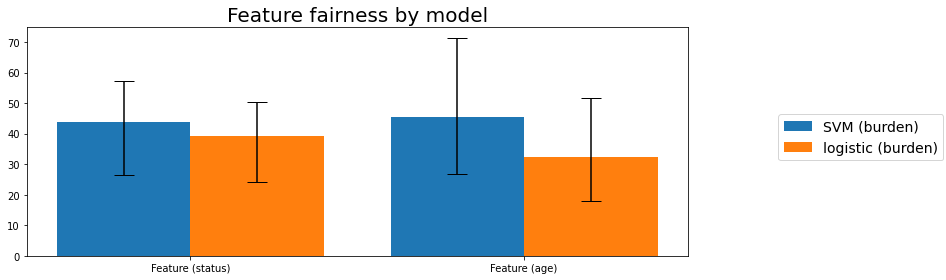

In [29]:
# Many scores also come with 95% confidence bounds, which we omitted above for the sake of brevity, but
# we can include those also.  In the example here we include the confidence bounds but only display the scores
# to a reduced level of detail to keep a smallish table for display purposes
df = construct_scores_dataframe(scores('fairness', result, max_depth=1))
display(df)

print("\n")

# Let's chart the fairness measure by feature for each model together with its confidence bounds for
# easier visual comparison:
%matplotlib inline
import matplotlib.pyplot as plt

features = ['Feature (status)', 'Feature (age)']
feature_scores = df[features]
feature_lower_bounds = df[[f + ' lower bound' for f in features]]
feature_upper_bounds = df[[f + ' upper bound' for f in features]]

fig, ax = plt.subplots(figsize=[12,4])
ax.set_title('Feature fairness by model', fontsize=20)
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink']
width = 0.4

ax.set_xticks(np.arange(len(features))+width)
ax.set_xticklabels(features)

for idx in range(len(df)):
    central_values = list(feature_scores.iloc[idx])
    lower_bounds = list(feature_lower_bounds.iloc[idx])
    upper_bounds = list(feature_upper_bounds.iloc[idx])
    lower_errors = [central_values[i] - lower_bounds[i] for i in range(len(central_values))]
    upper_errors = [upper_bounds[i] - central_values[i] for i in range(len(central_values))]

    ax.bar([width/2+idx*width+f_idx for f_idx in range(len(features))],
            central_values,
            width,
            yerr=[lower_errors, upper_errors],
            color=colors[idx],
            label=df.index[idx],
            capsize=10)

fig.legend(fontsize=14, bbox_to_anchor=(1.1,.6))
fig.tight_layout()
fig.subplots_adjust(right=0.8) 
plt.show()

In [30]:
scan_yaml = fairness_scan.extract_yaml()
print(scan_yaml)

dataset_schema:
  outcome_column: outcome
datasets:
- dataset_id: evaluation
  delimiter: ','
  file_type: loaded
  has_header: true
  quote_character: '"'
evaluation:
  evaluation_dataset_id: evaluation
  evaluation_types:
  - fairness
  fairness_grouping_features:
  - name: age
  - name: status
  name: model_auth_demo_fairness
  prediction_description: Determine whether a loan should be granted
  prediction_favorability: explicit
  prediction_values:
  - favorable: true
    name: Loan granted
    value: 1
  - favorable: false
    name: Loan denied
    value: 2
model_headers:
  default:
  - name: Content-Type
    value: application/json
model_use_case:
  model_use_case_id: model_auth_demo_fairness
  name: model_auth_demo_fairness
  task_type: binary-classification
models:
- model_id: SVM
  name: SVM
  prediction_value_order:
  - 1
  - 2
- model_id: logistic
  name: logistic
  prediction_value_order:
  - 1
  - 2



In [31]:
robustness_scan = CertifaiScanBuilder.create('model_auth_demo_robustness',
                                  prediction_task=task)

In [32]:
# Create a Certifai Model Object using the web service (from earlier) by passing the deployed web service url
first_model = CertifaiModel('SVM',
                            local_predictor=svm_model_proxy)
robustness_scan.add_model(first_model)

second_model = CertifaiModel('logistic',
                            local_predictor=logistic_model_proxy)
robustness_scan.add_model(second_model)

# Add corresponding model headers for service authentication and content-type

# add the default headers applicable to all models
robustness_scan.add_model_header(header_name='Content-Type',header_value='application/json')

In [33]:
# german_credit_eval_data_file = 'data/german_credit_eval_100.csv'
eval_dataset = CertifaiDataset('evaluation',
                               CertifaiDatasetSource.dataframe(df_sample))
robustness_scan.add_dataset(eval_dataset)

In [34]:
# Setup an evaluation for robustness on the above dataset using the model
robustness_scan.add_evaluation_type('robustness')
robustness_scan.evaluation_dataset_id = 'evaluation'

# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
robustness_scan.dataset_schema.outcome_feature_name = 'outcome'

# Run the scan.
# By default this will write the results into individual report files (one per model and evaluation
# type) in the 'reports' directory relative to the Jupyter root.  This may be disabled by specifying
# `write_reports=False` as below
# The result is a dictionary of dictionaries of reports.  The top level dict key is the evaluation type
# and the second level key is model id.
# Reports saved as JSON (which `write_reports=True` will do) may be visualized in the console app
result = robustness_scan.run(write_reports=False)

[--------------------] 2020-07-21 00:20:40.301538 - 0 of 2 reports (0.0% complete) - Starting scan with model_use_case_id: 'model_auth_demo_robustness' and scan_id: '93e48a7c7ec7'
[--------------------] 2020-07-21 00:20:40.301992 - 0 of 2 reports (0.0% complete) - Running robustness evaluation for model: SVM
[##########----------] 2020-07-21 00:22:16.166417 - 1 of 2 reports (50.0% complete) - Running robustness evaluation for model: logistic
[####################] 2020-07-21 00:23:28.350235 - 2 of 2 reports (100.0% complete) - Completed all evaluations


In [35]:
df = construct_scores_dataframe(scores('robustness', result, max_depth=1))
display(df)

,context,robustness,robustness lower bound,robustness upper bound
SVM,SVM,81.019818,75.853801,85.831858
logistic,logistic,86.906078,82.747603,90.368373


In [36]:
explanation_scan = CertifaiScanBuilder.create('model_auth_demo_explanation',
                                  prediction_task=task)

In [37]:
# Create a Certifai Model Object using the web service (from earlier) by passing the deployed web service url
first_model = CertifaiModel('SVM',
                            local_predictor=svm_model_proxy)
explanation_scan.add_model(first_model)

second_model = CertifaiModel('logistic',
                            local_predictor=logistic_model_proxy)
explanation_scan.add_model(second_model)

# Add corresponding model headers for service authentication and content-type

# add the default headers applicable to all models
explanation_scan.add_model_header(header_name='Content-Type',header_value='application/json')

In [38]:
# german_credit_eval_data_file = 'data/german_credit_eval_100.csv'
expl_dataset = CertifaiDataset('explanation',
                               CertifaiDatasetSource.dataframe(df_sample))
eval_dataset = CertifaiDataset('evaluation',
                               CertifaiDatasetSource.dataframe(df_sample))
explanation_scan.add_dataset(eval_dataset)
explanation_scan.add_dataset(expl_dataset)

In [39]:
# Setup an evaluation for explanation on the above dataset using the model
explanation_scan.add_evaluation_type('explanation')
explanation_scan.explanation_dataset_id = 'explanation'
explanation_scan.evaluation_dataset_id = 'evaluation'

# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
explanation_scan.dataset_schema.outcome_feature_name = 'outcome'

# Run the scan.
# By default this will write the results into individual report files (one per model and evaluation
# type) in the 'reports' directory relative to the Jupyter root.  This may be disabled by specifying
# `write_reports=False` as below
# The result is a dictionary of dictionaries of reports.  The top level dict key is the evaluation type
# and the second level key is model id.
# Reports saved as JSON (which `write_reports=True` will do) may be visualized in the console app
result = explanation_scan.run(write_reports=False)

[--------------------] 2020-07-21 00:23:28.450752 - 0 of 2 reports (0.0% complete) - Starting scan with model_use_case_id: 'model_auth_demo_explanation' and scan_id: '2a7013e8aec4'
[--------------------] 2020-07-21 00:23:28.450937 - 0 of 2 reports (0.0% complete) - Running explanation evaluation for model: SVM
[##########----------] 2020-07-21 00:25:07.122561 - 1 of 2 reports (50.0% complete) - Running explanation evaluation for model: logistic
[####################] 2020-07-21 00:26:21.944971 - 2 of 2 reports (100.0% complete) - Completed all evaluations


In [40]:
# The console app is the recommended way to view these, by saving the results to file
# (see previous cell), but programmatic analysis of the result here is also possible

# Here we'll extract the frequency of feature usage in generated counterfactuals for each model
def get_feature_frequency(model_id):
    # Extract the information for fairness of a particular model id
    local_model_explanation_info = result['explanation'][model_id]
    # Extract the full set of counterfactuals for this
    all_counterfactuals = [ind for r in local_model_explanation_info['explanations'] for ind in r['bestIndividuals']]

    def features_changed(counterfactual):
        # Each feature has an entry saying how it changed.  This will be one of:
        #   'unchanged'
        #   'changed' (categorical change)
        #   <numeric> (differnce from original value for numeric feaure)
        def no_change(diff):
            return (diff == 'unchanged') or diff == 0

        diffs = counterfactual['diff']
        return [idx for idx in range(len(diffs)) if not no_change(diffs[idx])]


    # Get the full list of model features from the schema
    features = local_model_explanation_info['model_schema']['feature_schemas']
    num_model_features = len(features)

    feature_names = np.array([f['name'] for f in features])
    
    # Count the changes for each feature across the dataset
    all_changes = np.zeros(num_model_features)
    for cf in all_counterfactuals:
        changed = features_changed(cf)
        for idx in changed:
            all_changes[idx] += 1
    return all_changes, feature_names

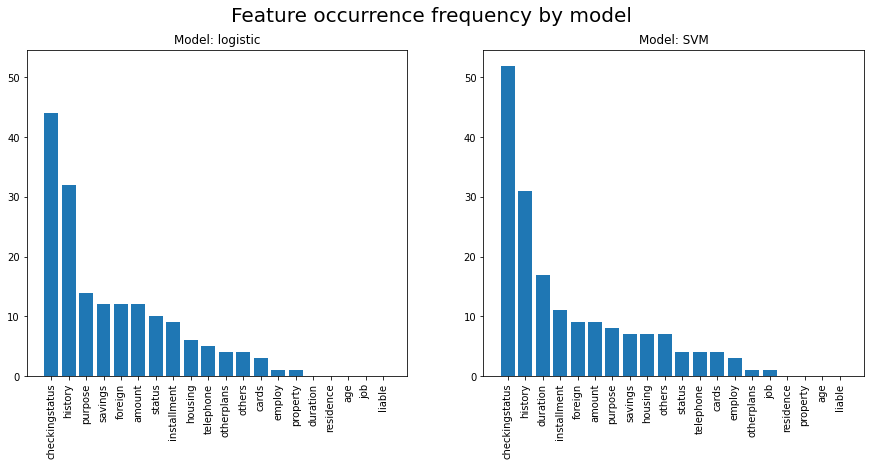

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_histogram(ax, model_id):
    all_changes, feature_names = get_feature_frequency(model_id)
    indexes = np.arange(len(all_changes))
    order = np.argsort(-all_changes)

    ax.bar(indexes,all_changes[order])

    ax.ylabel = 'Frequency'
    ax.set_title(f'Model: {model_id}')
    ax.set_xticks(indexes)
    ax.set_xticklabels(feature_names[order], rotation=90)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,6])
fig.suptitle('Feature occurrence frequency by model', fontsize=20)

plot_histogram(ax1, 'logistic')
plot_histogram(ax2, 'SVM')

# Put them both on the same scale
ylim = max(ax1.get_ylim()[1], ax2.get_ylim()[1])
ax1.set_ylim(top=ylim)
ax2.set_ylim(top=ylim)

plt.show()


In [42]:
explainability_scan = CertifaiScanBuilder.create('model_auth_demo_explainability',
                                  prediction_task=task)

In [43]:
# Create a Certifai Model Object using the web service (from earlier) by passing the deployed web service url
first_model = CertifaiModel('SVM',
                            local_predictor=svm_model_proxy)
explainability_scan.add_model(first_model)

second_model = CertifaiModel('logistic',
                            local_predictor=logistic_model_proxy)
explainability_scan.add_model(second_model)

# Add corresponding model headers for service authentication and content-type

# add the default headers applicable to all models
explainability_scan.add_model_header(header_name='Content-Type',header_value='application/json')

In [44]:
# german_credit_eval_data_file = 'data/german_credit_eval_100.csv'
expl_dataset = CertifaiDataset('explanation',
                               CertifaiDatasetSource.dataframe(df_sample))
eval_dataset = CertifaiDataset('evaluation',
                               CertifaiDatasetSource.dataframe(df_sample))
explainability_scan.add_dataset(eval_dataset)
explainability_scan.add_dataset(expl_dataset)

In [45]:
# Setup an evaluation for explanation on the above dataset using the model
explainability_scan.add_evaluation_type('explainability')
explainability_scan.explanation_dataset_id = 'explanation'
explainability_scan.evaluation_dataset_id = 'evaluation'

# Because the dataset contains a ground truth outcome column which the model does not
# expect to receive as input we need to state that in the dataset schema (since it cannot
# be inferred from the CSV)
explainability_scan.dataset_schema.outcome_feature_name = 'outcome'

# Run the scan.
# By default this will write the results into individual report files (one per model and evaluation
# type) in the 'reports' directory relative to the Jupyter root.  This may be disabled by specifying
# `write_reports=False` as below
# The result is a dictionary of dictionaries of reports.  The top level dict key is the evaluation type
# and the second level key is model id.
# Reports saved as JSON (which `write_reports=True` will do) may be visualized in the console app
result = explainability_scan.run(write_reports=False)

[--------------------] 2020-07-21 00:26:22.413949 - 0 of 2 reports (0.0% complete) - Starting scan with model_use_case_id: 'model_auth_demo_explainability' and scan_id: 'd8722dccc405'
[--------------------] 2020-07-21 00:26:22.414153 - 0 of 2 reports (0.0% complete) - Running explainability evaluation for model: SVM
[##########----------] 2020-07-21 00:27:58.270568 - 1 of 2 reports (50.0% complete) - Running explainability evaluation for model: logistic
[####################] 2020-07-21 00:29:09.022363 - 2 of 2 reports (100.0% complete) - Completed all evaluations


In [46]:
df = construct_scores_dataframe(scores('explainability', result, max_depth=1))
display(df)

,context,explainability,Num features (1),Num features (10),Num features (2),Num features (3),Num features (4),Num features (5),Num features (6),Num features (7),Num features (8),Num features (9)
SVM,SVM,90.55,48.0,0.0,34.0,13.0,4.0,1.0,0.0,0.0,0.0,0.0
logistic,logistic,90.95,58.0,0.0,23.0,11.0,8.0,0.0,0.0,0.0,0.0,0.0
